In [49]:
using CSV, DataFrames, Statistics, StatsBase, Distributions, JuMP, Gurobi, LinearAlgebra, Plots, Pkg
const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2022-09-11


Gurobi.Env(Ptr{Nothing} @0x00007f9f0c827c00, false, 0)

In [ ]:
include("adaptive_ensemble/src/main.jl")

BoundsError: BoundsError: attempt to access 9-element BitVector at index [0:5]

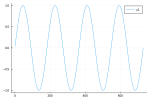

In [18]:
T = 365
period = 2
y = [sin(2*pi*period*t/T) for t=1:2T]
plot(y)

In [37]:
function create_y(T, period, bias, σ_pert)
    d = Normal(0, σ_pert)
    y_base = [sin(2*pi*period*t/T) for t=1:2T]
    y = y_base.+rand(d, size(y_base))
    return y
end

function create_ensemble_values(y, N_models, bias_range, std_range, δ_pert, σ_pert, total_drift_additive)
    #uniform distribution of models biases
    T = size(y)[1]
    d = Uniform(-bias_range, bias_range)
    
    #sample distribution of models biases
    biases = rand(d, N_models)
    
    #uniform distribution of models stds
    s = Uniform(0, std_range)
    
    #sample distribution of models biases
    variances = rand(s, N_models)
    
    #Create the features X by taking y and adding noise.
    X = zeros(T, N_models)

    for i=1:N_models
        d = Normal(biases[i], variances[i])
        X[:,i] = y.+ rand(d, T)
    end
    
    if total_drift_additive
        #### Perturbations on base learners because of data drift
        d = Normal(0, δ_pert)
        biases_perturb = rand(d, N_models)
        d = Uniform(0, σ_pert)
        variances_perturb = rand(d, N_models)
        for i=1:N_models
            d = Normal(biases_perturb[i], variances_perturb[i])
            X[:,i] = X[:,i] .+ [t/T for t=1:T].*rand(d, T)
        end
    end
    return X
end

create_ensemble_values (generic function with 2 methods)

In [38]:
y = create_y(365, 1, 0, 0.1)
X = create_ensemble_values(y, 10, 0.1, 0.15, 0.05, 0.05, true)

730×10 Matrix{Float64}:
  0.0150678   0.277899     0.0853916   …   0.0985742   -0.331979
  0.0825907  -0.00642895   0.0305574       0.174118    -0.00441157
 -0.178941   -0.343798    -0.247018       -0.103979    -0.287277
  0.15123    -0.053116     0.117299        0.226087    -0.0552882
  0.142063   -0.163221     0.139257        0.232606     0.188284
  0.192083    0.234672     0.209452    …   0.282864     0.176653
  0.0778102  -0.0663107    0.053836        0.162325     0.167174
  0.0454954   0.0443871    0.0486451       0.134731     0.0844227
  0.0959006   0.160253     0.0837969       0.198073     0.205933
  0.0971222  -0.159435     0.140663        0.1661      -0.0815373
  0.0525798   0.0109961    0.0632148   …   0.147017    -0.213311
  0.134512    0.200618     0.21542         0.227567    -0.131087
  0.239254    0.11875      0.181999        0.339894     0.499974
  ⋮                                    ⋱               
 -0.327391   -0.23864     -0.0702804      -0.175328    -0.382951
 -0.1

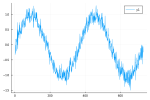

In [48]:
plot(X[:,10])

In [7]:
biases = rand(d, p)

5-element Vector{Float64}:
 -0.09920110878975748
 -0.0032894391110474402
 -0.027415657290163778
  0.027191886937924348
 -0.07305983913099548

# TESTING

In [55]:
function eval_method(args, X, y, y_true, split_, past, num_past, val, mean_y, std_y)

    n, p = size(X)
    split_index = floor(Int,n*split_)
    if val == -1
        val = size(X)[1]
    end

    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, max(split_index-num_past*past+1, 1), min(num_past*past, split_index), val, args["uncertainty"], args["last_yT"])
    println("There are ", size(X)[1], " samples in total.")
    println("We start training at index ", max(split_index-num_past*past+1, 1))
    println("We test between index ", max(split_index-num_past*past+1, 1)+1+min(num_past*past, split_index), " and ",  max(split_index-num_past*past+1, 1)+1+min(num_past*past, split_index)+val+1)

    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)

    β_l2_init = l2_regression(X0,y0,args["rho"], 0); #0 is for beta_stat which I removed

    #β_list_linear_adaptive_pure_Vt = zeros(val, p)
    β_list_linear_adaptive_trained_one = zeros(val, p)
    β_list_linear_adaptive_trained_one_standard = zeros(val, p)

    β_list_linear_adaptive_trained_one_err_rule = zeros(val, p)
    β_list_linear_adaptive_trained_one_standard_err_rule = zeros(val, p)


    #_, β0_0, V0_0, _ = adaptive_ridge_regression_exact_no_stable(vcat(X0,Xt), vcat(y0,yt), ρ, ρ, past)
    args["err_rule"] = false
    _, β0_0, V0_0, _ = adaptive_ridge_regression_exact_no_stable(args, X0, y0, args["rho_beta"], args["rho"], args["rho_V"], past)
    _, β0_1, V0_1 = adaptive_ridge_regression_exact_no_stable(args, X0, y0, 0, args["rho"], args["rho_V"], past)

    #We use the error instead of the forecasts.
    args["err_rule"] = true
    _, β0_0_err_rule, V0_0_err_rule, _ = adaptive_ridge_regression_exact_no_stable(args, X0, y0, args["rho_beta"], args["rho"], args["rho_V"], past)
    _, β0_1_err_rule, V0_1_err_rule, _ = adaptive_ridge_regression_exact_no_stable(args, X0, y0, 0, args["rho"], args["rho_V"], past)
    #_, β0_1, V0_1 = adaptive_ridge_regression_standard(args, X0, y0, args["rho"], args["rho_V"], past)

    #TODO: Uncomment
    #obj, β_linear_adaptive_pure_0_Vt, Vt_adaptive_pure, _ = adaptive_ridge_regression_exact_Vt(vcat(X0,Xt), vcat(y0,yt), ρ, ρ, past, 1)

    β_list_bandits_t = zeros(val, p-1)
    β_list_bandits_all = zeros(val, p-1)
    β_list_PA = zeros(val, p)
    #IMPORTANT: We initialize with equal weights but we could also initialize with l2 weights
    β_PA = ones(p)/(p)#β_l2_init[2:end]
    println("Optimization finished. Evaluation starts.")

    last_timesteps = zeros(val)

    for s=1:val

        #TODO check split_index with max(split inex, 1)
        if args["more_data_for_beta0"]
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, max(split_index-num_past*past+1, 1), s+(num_past-1)*past, past-1, args["uncertainty"], args["last_yT"])
        else
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, max(s+split_index-num_past*past+1, 1), (num_past-1)*past, past-1, args["uncertainty"], args["last_yT"])
        end

        #TODO: evaluate also if we change Vt regularly
        #obj, β_linear_adaptive_pure_0_Vt, Vt_adaptive_pure, _ = adaptive_ridge_regression_exact_Vt(vcat(X0,Xt), vcat(y0,yt), ρ, ρ, past, 1)


        #Line to get Z_{t+1}
        X_for_Z = X[split_index-past+s+1:split_index+s+1,:]
        X_for_Z[:,1] .= 1
        y_for_Z = y[split_index-past+s+1:split_index+s+1,:]

        args["err_rule"] = false
        X_, Z_test, y_ = get_X_Z_y(args, X_for_Z, y_for_Z, past)
        args["err_rule"] = true
        _, Z_test_err_rule, _ = get_X_Z_y(args, X_for_Z, y_for_Z, past)

        #BASELINES
        β_list_bandits_all[s,:] = compute_bandit_weights(vcat(X0,Xt)[:,2:end], vcat(y0,yt))
        β_list_bandits_t[s,:] = compute_bandit_weights(Xt[:,2:end], yt)
        β_PA = compute_PA_weights(0.01, β_PA, Matrix(Xt)[end,1:end], yt[end])
        β_list_PA[s,:] = β_PA
        #β_l2 = l2_regression(vcat(X0,Xt),vcat(y0,yt),ρ);
        #β_listl2[s,:] = β_l2

        #TODO Add if needed
        #β_list_linear_adaptive_pure_Vt[s,:] = β_linear_adaptive_pure_0_Vt + Vt_adaptive_pure[end,:,:] * Z_test[1,:]
        β_list_linear_adaptive_trained_one[s,:] = β0_0 + V0_0 * Z_test[1,:]
        β_list_linear_adaptive_trained_one_standard[s,:] = β0_1 + V0_1 * Z_test[1, :]

        β_list_linear_adaptive_trained_one_err_rule[s,:] = β0_0_err_rule + V0_0_err_rule * Z_test_err_rule[1,:]
        β_list_linear_adaptive_trained_one_standard_err_rule[s,:] = β0_1_err_rule + V0_1_err_rule * Z_test_err_rule[1, :]

        last_timesteps[s] = Z_test[1,end]
    end

    #TODO Best underlying model
    println("Evaluation finished. Metrics start.")
    X0, y0, Xt, yt, _, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, args["uncertainty"], args["last_yT"])
    _, _, _, _, yt_true, _, _ = prepare_data_from_y(X, y_true, 1, split_index, val, args["uncertainty"], args["last_yT"])

    # Unstandardize for metrics
    yt_true = yt_true.*std_y.+mean_y

    # Unstandardize predictions as well
    # The reason why we put 2:end is because the first element is the intercept term (1)
    err_mean = [abs(yt_true[s]-(mean(Xt[s,2:end]).*std_y.+mean_y)) for s=1:val]
    err_last_timestep = [abs(yt_true[s]-(last_timesteps[s].*std_y.+mean_y)) for s=2:val]
    err_best_model = get_best_model_errors(yt_true, Xt, mean_y, std_y)
    err_bandit_full = [abs(yt_true[s]-(dot(Xt[s,2:end],β_list_bandits_all[s,:]).*std_y.+mean_y)) for s=1:val]
    err_bandit_t = [abs(yt_true[s]-(dot(Xt[s,2:end],β_list_bandits_t[s,:]).*std_y.+mean_y)) for s=1:val]
    err_PA = [abs(yt_true[s]-(dot(Xt[s,1:end],β_list_PA[s,:]).*std_y.+mean_y)) for s=1:val]
    err_baseline = [abs(yt_true[s]-(dot(Xt[s,:],β_l2_init).*std_y.+mean_y)) for s=1:val]
    #err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]

    #TODO: Uncomment
    #err_linear_adaptive_pure_Vt = [abs(yt_true[s]-dot(Xt[s,:],β_list_linear_adaptive_pure_Vt[s,:])) for s=1:val]
    err_linear_adaptive_trained_one = [abs(yt_true[s]-(dot(Xt[s,:],β_list_linear_adaptive_trained_one[s,:]).*std_y.+mean_y)) for s=1:val]
    err_linear_adaptive_trained_one_standard = [abs(yt_true[s]-(dot(Xt[s,:],β_list_linear_adaptive_trained_one_standard[s,:]).*std_y.+mean_y)) for s=1:val]

    err_linear_adaptive_trained_one_err_rule = [abs(yt_true[s]-(dot(Xt[s,:],β_list_linear_adaptive_trained_one_err_rule[s,:]).*std_y.+mean_y)) for s=1:val]
    err_linear_adaptive_trained_one_standard_err_rule = [abs(yt_true[s]-(dot(Xt[s,:],β_list_linear_adaptive_trained_one_standard_err_rule[s,:]).*std_y.+mean_y)) for s=1:val]

    #TODO check get_metrics
    println("\n### Mean Baseline ###")
    get_metrics(args, "mean", err_mean, yt_true)

    println("\n### Last Timestep Baseline ###")
    get_metrics(args, "last_timestep", err_last_timestep, yt_true[2:end])

    println("\n### Best Model Baseline ###")
    get_metrics(args, "best_model", err_best_model, yt_true)

    println("\n### Bandits Full Baseline ###")
    get_metrics(args, "bandits_full", err_bandit_full, yt_true)

    println("\n### Bandits Only Last T Baseline ###")
    get_metrics(args, "bandits_recent", err_bandit_t, yt_true)

    println("\n### Passive-Aggressive Baseline ###")
    ### The Beta 0 that is originating from the adaptive formulation
    get_metrics(args, "PA", err_PA, yt_true)

    println("\n### β0 Baseline ###")
    get_metrics(args, "ridge", err_baseline, yt_true)

#     println("\n### β0 Baseline Retrained ###")
#     get_metrics(err_l2, yt_true)

    #TODO: Uncomment
#     println("\n### βt Linear Decision Rule Adaptive with NO Stable Part Vt ###")
#     ### Using Beta t+1 = Beta 0 + V0*Z_{t+1}, with Beta 0, V0 that is originating from the linear adaptive formulation with NO stable part
#     get_metrics(err_linear_adaptive_pure_Vt, yt_true)

    println("\n### βt Linear Decision Rule Adaptive with NO Stable Part and Trained ONCE ###")
    ### Using Beta t+1 = Beta 0 + V0*Z_{t+1}, with Beta 0, V0 that is originating from the linear adaptive formulation with NO stable part
    get_metrics(args, "adaptive_ridge_exact", err_linear_adaptive_trained_one, yt_true)

    println("\n### βt Linear Decision Rule Adaptive with NO Stable Part and Trained ONCE STANDARD ###")
    ### Using Beta t+1 = Beta 0 + V0*Z_{t+1}, with Beta 0, V0 that is originating from the linear adaptive formulation with NO stable part
    get_metrics(args, "adaptive_ridge_standard", err_linear_adaptive_trained_one_standard, yt_true)

    #SAME AS LAST 2, BUT WITH ERROR RULES
    println("\n### βt Linear Decision Rule Adaptive with NO Stable Part and Trained ONCE + ERROR RULE for Z ###")
    ### Using Beta t+1 = Beta 0 + V0*Z_{t+1}, with Beta 0, V0 that is originating from the linear adaptive formulation with NO stable part
    get_metrics(args, "adaptive_ridge_exact_err_rule", err_linear_adaptive_trained_one_err_rule, yt_true)

    println("\n### βt Linear Decision Rule Adaptive with NO Stable Part and Trained ONCE STANDARD + ERROR RULE for Z ###")
    ### Using Beta t+1 = Beta 0 + V0*Z_{t+1}, with Beta 0, V0 that is originating from the linear adaptive formulation with NO stable part
    get_metrics(args, "adaptive_ridge_standard_err_rule", err_linear_adaptive_trained_one_standard_err_rule, yt_true)

end

LoadError: LoadError: UndefVarError: @add_arg_table! not defined
in expression starting at In[55]:4

In [133]:
#set a size for training data
N0 = 900

#set a size for testing data
Nt = 100

#set a number of underlying models
p = 10

δ = 0.5
δ_pert = 0.5
σ_pert = 1
#y = randn(N0+Nt)
n0 = floor(Int, size(y_safi)[1]/2)
y_true = y_safi[n0-N0:n0+Nt-1]
y = copy(y_true)
d = Uniform(-δ, δ)
biases = rand(d, p)
variances = rand(p)
gradual_after = false
gradual_before = true

#Create the features X by taking y and adding noise.
X = zeros(N0+Nt, p)

for i=1:p
    d = Normal(biases[i], variances[i])
    X[:,i] = y.+ rand(d, N0+Nt)
end

#### Perturbations on base learners because of data drift
d = Normal(0, δ_pert)
biases_perturb = rand(d, p)
d = Uniform(0, σ_pert)
variances_perturb = rand(d, p)

if gradual_after
    for i=1:p
        d = Normal(biases_perturb[i], variances_perturb[i])
        #We add the perturbation for each model 
        #We make the perturbations more and more intense across time
        X[N0+1:N0+Nt,i] = X[N0+1:N0+Nt,i].+rand(d, Nt).*[t/Nt for t=1:Nt]
    end
end

if gradual_before
    for i=1:p
        for t=1:Nt
            #We compute the perturbation for each model 
            #We make the perturbations more and more intense across time
            d = Normal(t/Nt*δ_pert, t/Nt*σ_pert)
            X[N0+t,i] = X[N0+t,i]+rand(d)
        end
    end
else
    for i=1:p
        d = Normal(biases_perturb[i], variances_perturb[i])
        #We add the perturbation for each model 
        #We make the perturbations more and more intense across time
        X[N0+1:N0+Nt,i] = X[N0+1:N0+Nt,i].+rand(d, Nt)
    end
end

In [134]:
#### Perturbations on y
perturb_y = true
perturb_y_norm = true
y_bias = -0.1
y_var = 0.5

if perturb_y
    if perturb_y_norm
        d = Normal(y_bias, y_var)
        y[N0+1:N0+Nt] = y[N0+1:N0+Nt] .+ rand(d, Nt)
    else
        d = Uniform(-y_bias, y_bias)
        y[N0+1:N0+Nt] = y[N0+1:N0+Nt] .+ rand(d, Nt)
    end
end
;

In [135]:
split_ = N0/(N0+Nt)
past = 10
num_past = floor(Int, Nt/past)

last_yT = false
max_cuts = 10
verbose = false

uncertainty = 0.#1
δ_inf = 0.02
ϵ_inf = 0.02

ϵ_l2 = 0.05
δ_l2 = 0.05

reg = 1/(past*num_past)
ρ = 0.1
val = Nt-1; #n-split_index;

fix_β0 = false
more_data_for_β0 = false
benders = false
ridge = true

eval_method(X, y, y_true, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge, linear_adapt)

LoadError: UndefVarError: linear_adapt not defined

In [136]:
split_ = N0/(N0+Nt)
past = 20
num_past = floor(Int, Nt/past)

last_yT = false
max_cuts = 10
verbose = false

uncertainty = 0.#1
δ_inf = 0.02
ϵ_inf = 0.02

ϵ_l2 = 0.05
δ_l2 = 0.05

reg = 1/(past*num_past)
ρ = 0.1
val = Nt-1; #n-split_index;

fix_β0 = false
more_data_for_β0 = false
benders = false
ridge = true

eval_method(X, y, y_true, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge)

LoadError: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.

In [8]:
function get_Y(X, t)
    "
    Create the vector of data for the dual problem
    "
    T, p = size(X)
    Y = zeros(1,T*p)
    Y[(t-1)*p+1:t*p] = X[t,:]
    return Y
end

function get_Z(X)
    T, p = size(X)
    Z = zeros(T, T*p)
    for t=1:T
        Z[t,:] = get_Y(X,t)
    end
    return Z
end

function get_A(X, t)
    T, p = size(X)
    A = zeros(p,T*p)
    A[:,(t-1)*p+1:t*p] = 1 * Matrix(I, p, p)
    return A
end


function solve_model_benders(m)
    "Solve the Benders master problem
    "
    optimize!(m)
    U_OA = objective_value(m)
    #println("U_OA from solve ", U_OA)
    return value.(m[:β]), value.(m[:α]), U_OA
end

function S_primal(X, y, β0, epsilon, delta)

    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p])
    @variable(model, b[i=1:n]>=0)

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))

    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)


    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)

    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)

    optimize!(model);

    return objective_value(model), getvalue.(β)
end


function R(X, D_min, D_max, β0, epsilon, delta)
    "
    Full dual problem
    "
    T, p = size(X)
    Z = get_Z(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)

    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0)
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0)
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    @variable(model, y[j=1:T])


    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)


    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)

    # Add objective
    @objective(model, Max, 2*dot(λ[1,:],y) - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)) #
    optimize!(model)
    return objective_value(model), getvalue.(y), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

function master_problem(X0, Xt, y0, D_min, D_max, threshold = 0.1, epsilon = 0.1, delta = 0.1, reg = 1, ρ = 1, max_cuts = 10, verbose=0)
    n, p = size(X0)
    T, p = size(Xt)
    #Z = get_Z(X0)
    L_BD = -10000
    U_BD = 10000
    cuts = 0

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, α)
    @variable(model, β[j=1:p])

    #Warm start for β

    β_val0 = l2_regression(X0, y0, ρ)#Random.rand(p)#
    #β_val0 = Random.rand(p)


    #Initialization
    _, y_val0, λ_val0, ν_val0, μ_val0 = R(Xt, D_min, D_max, β_val0, epsilon, delta)

    #First constraint
    @constraint(model, α >= 2*dot(λ_val0[1,:],y_val0) - sum(y_val0)
                            - delta * sum(sum(ν_val0[1,t,i]+ν_val0[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val0[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val0[2,t,:]) for t = 1:T))

    # Add objective
    @objective(model, Min, 1/n*sum((y0[i]-sum(X0[i,j]*β[j] for j=1:p))^2 for i=1:n) + reg*α + ρ*sum(β[j]^2 for j=1:p))

    while cuts < max_cuts && U_BD - L_BD > threshold
        if verbose
            println("Lower: ", L_BD, " Upper: ", U_BD)
        end
        cuts += 1

        #Solve current Master Problem
        β_val, α_val, L_BD = solve_model_benders(model)
        U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)

        U_BD = 1/n*sum((y0[i]-sum(X0[i,j]*β_val[j] for j=1:p))^2 for i=1:n) + reg*U_OA + ρ*sum(β_val[j]^2 for j=1:p)

        if U_BD - L_BD > threshold
            @constraint(model, α >= 2*dot(λ_val[1,:],y_val) - sum(y_val)
                            - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val[2,t,:]) for t = 1:T))
            if verbose
                println("Cut added")
                println("y_val: ", y_val)
            end
        end
    end
    optimize!(model)
    β_val, α_val, L_BD = solve_model_benders(model)
    U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
    if verbose
        println("Final model Obj value: ", objective_value(model))
        println("Lower: ", L_BD, " Upper: ", U_BD)
        println("Final y: ", y_val)
    end
    return objective_value(model), getvalue.(β), getvalue.(α), y_val#, getvalue.(ν), getvalue.(μ)
end

master_problem (generic function with 8 methods)

In [9]:
function R2(y_true, y_test)
    SSR = sum(abs2.(y_true.-y_test))
    SST = sum(abs2.(y_true.-mean(y_true)))
    return 1 - SSR/SST
end

function R2_err(err, y_true)
    SSR = sum(abs2.(err))
    SST = sum(abs2.(y_true.-mean(y_true)))
    return 1 - SSR/SST
end


function compute_CVaR(errs, α_risk)
#     '''
#     Compute the Conditional Value at Risk
#     :param X: Either the data matrix X or the errors
#     :param y: the target values
#     :param alpha: the risk value
#     :param beta:
#     :param b0:
#     :param errs: whether you want to input the data matrix X or the errors
#     :return: the model and the CVaR
#     '''
    n = size(errs)[1]
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, τ)
    @variable(model, z[1:n] >= 0)

    # Add objective
    @objective(model, Min, sum(z)/(α_risk * n) + τ)

    @constraint(model, [1:n], errs .- τ .<= z)

    optimize!(model)

    return objective_value(model)
end


function eval_method(X, y, y_true, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT,
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose,
        fix_β0, more_data_for_β0, benders, ridge)

    threshold_benders = 0.01
    n, p = size(X)
    split_index = floor(Int,n*split_)
    #TODO change spli_index with max(split inex, 1)
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    β_l2_init = l2_regression(X0,y0,ρ);
    for s=1:val

        if more_data_for_β0
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        else
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        end


        if benders
            ##TODO handle fix_beta0
            obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold_benders, ϵ_inf, δ_inf, reg, ρ, max_cuts, verbose)
            _, βt_val = S_primal(Xt, y_val, β0_val, ϵ_inf, δ_inf);
        else
            if ridge
                obj, βt_val, β0_val = master_primal_l2_ridge(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            else
                obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            end
        end

        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(X0,y0,ρ);
        β_listl2[s,:] = β_l2

    end

    X0, y0, Xt, yt, _, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    _, _, _, _, yt_true, _, _ = prepare_data_from_y(X, y_true, 1, split_index, val, uncertainty, last_yT)

    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]

    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    println("R2 : ", R2_err(err_baseline, yt_true))

    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    println("R2 : ", R2_err(err_l2, yt_true))

    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))
    println("R2 : ", R2_err(err_0, yt_true))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
    println("R2 : ", R2_err(err_t, yt_true))
end


function prepare_data_from_y(X, y, n0, n, m, uncertainty, last_yT = false)

    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = yt_true
    if last_yT
        yt_true[m] = mean(Xt[m])
    end

    D_min = yt .- uncertainty.*abs.(yt)
    D_max = yt .+ uncertainty.*abs.(yt)

    return X0, y0, Xt, yt, yt_true, D_min, D_max
end


function l2_regression(X, y, rho; solver_output=0)
    n,p = size(X)

    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", solver_output)
    set_optimizer_attribute(model, "NonConvex", 2)

    @variable(model,beta[j=1:p])
    @variable(model, sse>=0)
    #@variable(model, reg>=0)
    @constraint(model, sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n) <= sse)
    #@constraint(model, sum(beta[j]^2 for j=1:p)<=reg)
    @objective(model,Min, 1/n*sse + rho*sum(beta[j]^2 for j=1:p))

    optimize!(model)
    #println("Obj ", objective_value(model))
    return value.(beta)
end

l2_regression (generic function with 1 method)

In [10]:




function master_primal_l2(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ, ϵ_l2, δ_l2, β0_fix = false, β0_val = 0)

    M = 1000
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p])
    @variable(model, b[i=1:n]>=0)
    @variable(model, β0[j=1:p])
    @variable(model, z[i=1:n], Bin)
    @variable(model, y[i=1:n])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0)
        + reg*sum(b[i] for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))

    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)

    if β0_fix
        @constraint(model, β0 .== β0_val)
    end
    @constraint(model, res_plus_min[i=1:n],  - y[i] + dot(Xt[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus_min[i=1:n],  y[i] - dot(Xt[i,:],β[i,:]) <= b[i])

    @constraint(model,  y .== Dmax.*z + Dmin.*(1 .-z))
    #@constraint(model,  y .== Dmax.*(1 .-z) + Dmin.*z)

    #@constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:])-Dmin[i])^2 + M*z[i] >= (dot(Xt[i,:],β[i,:])-Dmax[i])^2)
    @constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:]) - Dmin[i])^2 - (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*z[i] >= 0)


    #@constraint(model, bigM2[i=1:n],  (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*(1-z[i]) >= (dot(Xt[i,:],β[i,:])-Dmin[i])^2)

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)

    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)

    @constraint(model, sq_0[i=1:n], sum((β[i,:] .- β0).^2) .<= ϵ_l2)
    @constraint(model, sq_t[i=2:n], sum((β[i,:] .- β[i-1,:]).^2) .<= δ_l2)

    #@constraint(model, abs_0[i=1:n], sum(abs.(β[i,:] .- β0)) .<= ϵ_l1)
    #@constraint(model, abs_t[i=2:n], sum(abs.(β[i,:] .- β[i-1,:])) .<= δ_l1)

    optimize!(model);
    #println("SUM ", sum(getvalue.(b)))
    #println("Y ", getvalue.(y))
    return objective_value(model), getvalue.(β), getvalue.(β0)
end




function master_primal_l2_ridge(X0, Xt, y0, Dmin, Dmax, epsilon, delta, reg, ρ, ϵ_l2, δ_l2, β0_fix = false, β0_val = 0)

    M = 1000
    n0, p = size(X0)
    n, _ = size(Xt)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p])
    @variable(model, β0[j=1:p])
    @variable(model, z[i=1:n], Bin)
    @variable(model, y[i=1:n])
    # Add objective
    @objective(model, Min, 1/n0*sum((y0[i]-sum(X0[i,j]*β0[j] for j=1:p))^2 for i=1:n0)
        + reg*sum((y[i] - dot(Xt[i,:],β[i,:]))^2 for i=1:n) + ρ*sum(β0[j]^2 for j=1:p))

    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)

    if β0_fix
        @constraint(model, β0 .== β0_val)
    end

    @constraint(model,  y .== Dmax.*z + Dmin.*(1 .-z))
    #@constraint(model,  y .== Dmax.*(1 .-z) + Dmin.*z)

    #@constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:])-Dmin[i])^2 + M*z[i] >= (dot(Xt[i,:],β[i,:])-Dmax[i])^2)
    @constraint(model, bigM[i=1:n], (dot(Xt[i,:],β[i,:]) - Dmin[i])^2 - (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*z[i] >= 0)


    #@constraint(model, bigM2[i=1:n],  (dot(Xt[i,:],β[i,:])-Dmax[i])^2 + M*(1-z[i]) >= (dot(Xt[i,:],β[i,:])-Dmin[i])^2)

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)

    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)

    @constraint(model, sq_0[i=1:n], sum((β[i,:] .- β0).^2) .<= ϵ_l2)
    @constraint(model, sq_t[i=2:n], sum((β[i,:] .- β[i-1,:]).^2) .<= δ_l2)

    #@constraint(model, abs_0[i=1:n], sum(abs.(β[i,:] .- β0)) .<= ϵ_l1)
    #@constraint(model, abs_t[i=2:n], sum(abs.(β[i,:] .- β[i-1,:])) .<= δ_l1)

    optimize!(model);
    #println("SUM ", sum(getvalue.(b)))
    #println("Y ", getvalue.(y))
    return objective_value(model), getvalue.(β), getvalue.(β0)
end

master_primal_l2_ridge (generic function with 3 methods)

# Linear rule

In [24]:
function adaptive_ridge_regression_standard(X, y, ρ_β0, ρ_V0, T)
    
#     Adaptive ridge: does not run fast
    

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)
    X, Z, y = get_X_Z_y(X, y, T)

    N, P = size(X)
    # Add variables

    @variable(model, β0[j=1:P])
    @variable(model, V0[j=1:P, k=1:T*P+T])
    @variable(model, t>=0)

    # Add objective
    @objective(model, Min, t + ρ_β0 * sum(β0[j]^2 for j=1:P)
                            + ρ_V0 * sum(V0[j,k]^2 for j=1:P for k=1:T*P+T)
    )

    @constraint(model, t >= 1 / N * sum((y[i] - sum(X[i, j] * (β0[j]
                 + sum(V0[j, l] * Z[i, l] for l=1:(T * P + T))
                 )
                for j=1:P))^2
        for i=1:N))

    optimize!(model);
    return objective_value(model), getvalue.(β0), getvalue.(V0), Z
end

adaptive_ridge_regression_standard (generic function with 1 method)

In [174]:
function adaptive_ridge_regression_before_exact(X, y, ρ_β0, ρ_V0, T)
    
    #Version with actual robust equivalence
    #We use beta t
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 1)
    X, Z, y = get_X_Z_y(X, y, T)

    N, P = size(X)
    # Add variables

    @variable(model, β0[j=1:P])
    @variable(model, V0[j=1:P, k=1:T*P+T])
    @variable(model, t>=0)
    @variable(model, β[t=1:N,j=1:P])

    # Add objective
    @objective(model, Min, t + ρ_β0 * sum(β0[j]^2 for j=1:P)
                            + ρ_V0 * sum(V0[j,k]^2 for j=1:P for k=1:T*P+T)
    )

    @constraint(model, t >= 1 / N * sum((y[i] - sum(transpose(X[i, :])*β[i,:]))^2 for i=1:N))
        
    @constraint(model, [i=1:N], β[i,:] .== β0+V0*Z[i,:])

    optimize!(model);
    return objective_value(model), getvalue.(β0), getvalue.(V0), getvalue.(β)
end

adaptive_ridge_regression_before_exact (generic function with 1 method)

In [188]:
function adaptive_ridge_regression_exact(X, y, ρ_β0, ρ_V0, T, N0)
    
    #Version with actual robust equivalence
    #The formula for the regularization is different
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV))
    set_optimizer_attribute(model, "OutputFlag", 0)
    X, Z, y = get_X_Z_y(X, y, T)

    N, P = size(X)
    # Add variables

    @variable(model, β0[j=1:P])
    @variable(model, V0[j=1:P, k=1:T*P+T])
    @variable(model, t>=0)
    @variable(model, β[t=1:N,j=1:P])

    # If no stable part, then no reg
    if N0 == 1
        ρ_β0 = 0
    end
    
    # Add objective
    @objective(model, Min, t + 1/N0*ρ_β0 * sum(β0[j]^2 for j=1:P)
                            + 1/(N-N0)*ρ_V0 * sum(β[t,k]^2 for t=1:N for k=1:P)
    )

    @constraint(model, t >= 1 / N * sum((y[i] - sum(transpose(X[i, :])*β[i,:]))^2 for i=1:N))
    
    #stable and adaptive part
    @constraint(model, [i=N0:N], β[i,:] .== β0+V0*Z[i,:])
    @constraint(model, [i=1:N0-1], β[i,:] .== β0)

    optimize!(model);
    return objective_value(model), getvalue.(β0), getvalue.(V0), getvalue.(β)
end

adaptive_ridge_regression_exact (generic function with 2 methods)

In [12]:
function get_X_Z_y(X, y, T)
    """
    Input: training data X and corresponding labels y ; T: how many time-steps from the past to be used
    Output: the past features X with past targets y as a Z training data (no present features)
    """
    n, p = size(X)
    #T past time steps * p features + T targets
    Z = ones(n-T, T*p+T)
    for i=T+1:n
        for t=1:T
            Z[i-T,1+p*(t-1):p*t] = X[i-t,:]
        end
        Z[i-T, (p*T+1):end] = y[i-T:i-1]
    end
    return X[T+1:end,:], Z, y[T+1:end]
end

get_X_Z_y (generic function with 1 method)

In [13]:
e, Z, f = get_X_Z_y(X[1:5,1:2], y[1:5], 3)

([0.953041262548516 0.4782870249686575; 1.0535457742742587 0.334867774903859], [0.6507019593290054 0.4323663266396612 … -0.24864108988725883 0.4349146279684725; 0.953041262548516 0.4782870249686575 … 0.4349146279684725 0.7909332310183326], [0.7909332310183326, 0.7909332310183326])

In [164]:
obj, β0, V0, Z = adaptive_ridge_regression_standard(X[1:100,1:3], y[1:100], 0.1, 0.1, 3)
println(obj)

0.019454798289416986


In [165]:
β0+V0*Z[1,:]

3-element Vector{Float64}:
 0.1504249753800681
 0.4548341433068424
 0.14489314118672222

In [191]:
obj, β0, V0, β = adaptive_ridge_regression_exact(X[1:100,1:3], y[1:100], 0, 0.1, 3, 16)
println(obj)

0.5860827402650841


In [187]:
obj, β0, V0, β = adaptive_ridge_regression_exact(X[1:100,1:3], y[1:100], 0, 0.1, 3, 0)
println(obj)

0.5852809828471135


In [177]:
obj, β0, V0, β = adaptive_ridge_regression_before_exact(X[1:100,1:3], y[1:100], 0.1, 0.1, 3)
println(obj)
println(β0+V0*Z[1,:])
println(β[1,:])

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 291 rows, 331 columns and 4074 nonzeros
Model fingerprint: 0x6c09b65a
Model has 39 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e-02, 3e+00]
  QMatrix range    [1e-06, 8e-02]
  QLMatrix range   [6e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [8e-01, 8e-01]
Presolve time: 0.00s
Presolved: 391 rows, 432 columns, 4759 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 41
 Free vars  : 291
 AA' NZ     : 4.854e+03
 Factor NZ  : 1.827e+04
 Factor Ops : 8.039e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual    

In [170]:
_, β0, V0, β, X1, Z1 = adaptive_ridge_regression_exact_test(X[1:100,1:3], y[1:100], 0.1, 0.1, 3)
β[1,:]

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 291 rows, 331 columns and 4074 nonzeros
Model fingerprint: 0xac638d92
Model has 39 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e-02, 3e+00]
  QMatrix range    [2e-01, 1e+01]
  QLMatrix range   [6e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [8e-01, 8e-01]
Presolve removed 291 rows and 291 columns
Presolve time: 0.00s
Presolved: 42 rows, 83 columns, 864 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.600e+02
 Factor NZ  : 9.030e+02
 Factor Ops : 2.558e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual

3-element Vector{Float64}:
 0.1504249753800681
 0.45483414330684235
 0.14489314118672222

In [157]:
N, P = size(X1)
i = 1
T = 3
sum(X1[i, j] * (β0[j]+ sum(V0[j, l] * Z1[i, l] for l=1:(T * P + T))) for j=1:P)

0.533767797757831

In [151]:
transpose(X1[i,:])*β[i,:]

0.533767797757831

In [156]:
j = 1
println(β0[j]+sum(V0[j, l] * Z[i, l] for l=1:(T * P + T)))
println(β0+V0*Z[i,:])
println()

0.1504249753800681
[0.1504249753800681, 0.4548341433068424, 0.14489314118672222]


In [16]:
function evaluate_adaptive(X, y, y_true, β0, V0, T)
    X, Z, y = get_X_Z_y(X, y, T)
    
    N, P = size(X)

    pred = [sum(X[i, j] * (β0[j] + sum(V0[j, :] .* Z[i, :])) for j=1:P) for i=1:N]
    if size(y_true) == size(pred)
        err = [abs(y_true[i]-pred[i]) for i=1:N]
    else
        y_true = y_true[T+1:end]
        err = [abs(y_true[i]-pred[i]) for i=1:N]
    end
    return err
end

evaluate_adaptive (generic function with 1 method)

In [195]:
function evaluate_adaptive_retrained(X, y, y_true, β0_list, V0_list, T)
    X, Z, y = get_X_Z_y(X, y, T)
    
    N, P = size(X)

    pred = [sum(X[i, j] * (β0_list[i,j] + sum(V0_list[i, j, :] .* Z[i, :])) for j=1:P) for i=1:N]
    if size(y_true) == size(pred)
        err = [abs(y_true[i]-pred[i]) for i=1:N]
    else
        y_true = y_true[T+1:end]
        err = [abs(y_true[i]-pred[i]) for i=1:N]
    end
    return err
end

evaluate_adaptive_retrained (generic function with 1 method)

In [435]:
pred, err = evaluate_adaptive(X[1:100,1:3], y[1:100], y[4:100], β0, V0, 3)

([0.2772791481270517, -0.22139104249186187, 0.25353125721465, 0.13052228762534424, 0.16184232903639695, 0.02133275894336177, -0.23829147212091226, 0.14926772611852196, 0.28826028113700647, 0.7460128800839689  …  0.6974694989745849, 0.4334507651952026, 0.4535167025297599, 0.4228111533412082, -0.9470370564072363, -0.004111494312688896, 0.12274140243903106, 0.08108513878897414, -1.4025705199739362, 0.08251350395763898], [0.7111257347162706, 0.768332857553357, 0.1994216466416816, 0.6812973681052467, 0.08794262534614797, 0.24054297764516547, 0.02174221306394139, 0.4729100683816176, 0.04127284032870793, 0.5794229469798875  …  0.29188476681020137, 0.3992553152476475, 0.02696830662909544, 0.5024620796474668, 0.7050416471102421, 0.23408638321844036, 0.4254973199898675, 0.7075806393798176, 0.9146849288371715, 0.6178682421677187])

In [196]:
function eval_method(X, y, y_true, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT,
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose,
        fix_β0, more_data_for_β0, benders, ridge, linear_adapt)

    threshold_benders = 0.01
    n, p = size(X)
    split_index = floor(Int,n*split_)
    #TODO change spli_index with max(split inex, 1)
    X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, num_past*past, val, uncertainty, last_yT)

    β_list0 = zeros(val, p)
    β_listt = zeros(val, p)
    β_listl2 = zeros(val, p)
    β_l2_init = l2_regression(X0,y0,ρ);
    β0_list_linear_adapt = zeros(val, p)
    V0_list_linear_adapt = zeros(val, p, (past-1)*p+past-1)
    err = ones(val)
    
    ###Linear decision rule
    _, β0_0, V0_0 = adaptive_ridge_regression_standard(X0, y0, ρ, ρ, past-1)
    print(size(V0))
    
    for s=1:val
        #TODO Check how much I use from the past
        if more_data_for_β0
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, split_index-num_past*past+1, s+(num_past-1)*past, past-1, uncertainty, last_yT)
        else
            X0, y0, Xt, yt, yt_true, D_min, D_max = prepare_data_from_y(X, y, s+split_index-num_past*past+1, (num_past-1)*past, past-1, uncertainty, last_yT)
        end

        if benders
            ##TODO handle fix_beta0
            obj, β0_val, α, y_val = master_problem(X0, Xt, y0, D_min, D_max, threshold_benders, ϵ_inf, δ_inf, reg, ρ, max_cuts, verbose)
            _, βt_val = S_primal(Xt, y_val, β0_val, ϵ_inf, δ_inf);
        else
            if ridge
                obj, βt_val, β0_val = master_primal_l2_ridge(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            else
                obj, βt_val, β0_val = master_primal_l2(X0, Xt, y0, D_min, D_max, ϵ_inf, δ_inf, reg, ρ, ϵ_l2, δ_l2, fix_β0, β_l2_init)
            end
        end
        
        if linear_adapt
            #err[s] = evaluate_adaptive(vcat(X0[end-past+2:end,:],Xt), vcat(y0[end-past+2:end,:],yt), yt_true, β0, V0, past)
            _, β0, V0 = adaptive_ridge_regression_standard(vcat(X0,Xt), vcat(y0,yt), ρ, ρ, past-1)
            β0_list_linear_adapt[s,:] = β0
            V0_list_linear_adapt[s,:,:] = V0
            N = size(X0)[1]
        end
        
        β_listt[s,:] = βt_val[past-1,:]
        β_list0[s,:] = β0_val
        β_l2 = l2_regression(vcat(X0,Xt),vcat(y0,yt),ρ);
        β_listl2[s,:] = β_l2

    end

    X0, y0, Xt, yt, _, D_min, D_max = prepare_data_from_y(X, y, 1, split_index, val, uncertainty, last_yT)
    _, _, _, _, yt_true, _, _ = prepare_data_from_y(X, y_true, 1, split_index, val, uncertainty, last_yT)

    N = size(X0)[1]
    err_linear_rule = evaluate_adaptive(vcat(X0[N-past+2:end,:],Xt), vcat(y0[N-past+2:end,:],yt), yt_true, β0_0, V0_0, past-1)
    err_linear_rule_retrained = evaluate_adaptive_retrained(vcat(X0[N-past+2:end,:],Xt), vcat(y0[N-past+2:end,:],yt), 
        yt_true, β0_list_linear_adapt, V0_list_linear_adapt, past-1)
    
    err_0 = [abs(yt_true[s]-dot(Xt[s,:],β_list0[s,:])) for s=1:val]
    err_t = [abs(yt_true[s]-dot(Xt[s,:],β_listt[s,:])) for s=1:val]
    err_baseline = [abs(yt_true[s]-dot(Xt[s,:],β_l2_init)) for s=1:val]
    err_l2 = [abs(yt_true[s]-dot(Xt[s,:],β_listl2[s,:])) for s=1:val]

    println("\n### β0 Baseline ###")
    println("MAE Baseline: ", mean(err_baseline))
    println("CVAR 0.05 :", compute_CVaR(err_baseline, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_baseline, 0.15))
    println("R2 : ", R2_err(err_baseline, yt_true))

    println("\n### β0 Baseline Retrained ###")
    println("MAE Baseline: ", mean(err_l2))
    println("CVAR 0.05 :", compute_CVaR(err_l2, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_l2, 0.15))
    println("R2 : ", R2_err(err_l2, yt_true))
    
    println("\n### β0 V0 Linear rule Adaptive ###")
    println("MAE Baseline: ", mean(err_linear_rule))
    println("CVAR 0.05 :", compute_CVaR(err_linear_rule, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_linear_rule, 0.15))
    println("R2 : ", R2_err(err_linear_rule, yt_true))
    
    println("\n### β0 V0 Linear rule Adaptive Retrained ###")
    println("MAE Baseline: ", mean(err_linear_rule_retrained))
    println("CVAR 0.05 :", compute_CVaR(err_linear_rule_retrained, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_linear_rule_retrained, 0.15))
    println("R2 : ", R2_err(err_linear_rule_retrained, yt_true))

    println("\n### β0 Adaptive ###")
    println("MAE 0: ", mean(err_0))
    println("CVAR 0.05 :", compute_CVaR(err_0, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_0, 0.15))
    println("R2 : ", R2_err(err_0, yt_true))

    println("\n### βt Adaptive ###")
    println("MAE t: ", mean(err_t))
    println("CVAR 0.05 :", compute_CVaR(err_t, 0.05))
    println("CVAR 0.15 :", compute_CVaR(err_t, 0.15))
    println("R2 : ", R2_err(err_t, yt_true))
end

eval_method (generic function with 2 methods)

In [198]:
linear_adapt = true
split_ = N0/(N0+Nt)
past = 5
num_past = 20#floor(Int, Nt/past)

last_yT = false
max_cuts = 10
verbose = false

uncertainty = 0.#1
δ_inf = 0.02
ϵ_inf = 0.02

ϵ_l2 = 0.05
δ_l2 = 0.05

reg = 1/(past*num_past)
ρ = 0.1
val = Nt-1; #n-split_index;

fix_β0 = false
more_data_for_β0 = false
benders = false
ridge = true

eval_method(X, y, y_true, split_, past, num_past, val, uncertainty, ϵ_inf, δ_inf, last_yT, 
        ϵ_l2, δ_l2, ρ, reg, max_cuts, verbose, 
        fix_β0, more_data_for_β0, benders, ridge, linear_adapt)

(3, 12)

LoadError: Gurobi Error 10020: Constraint Q not PSD (diagonal adjustment of 1.1e-05 would be required). Set NonConvex parameter to 2 to solve model.